<a href="https://colab.research.google.com/github/StatsAI/streamlit_image_search_db/blob/main/Image_Search_Vector_DB_New.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install jupyter pandas sentence_transformers "qdrant_client~=1.3.0" pyarrow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 1.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.9/121.9 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 40.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 37.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 32.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.4/75.4 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.6/311.6 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.5/74.5 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 34.2 MB/s eta 0:00:00

In [2]:
import requests
import zipfile
import os
import io
import pandas as pd
from typing import List

from tqdm import tqdm
import numpy as np
from torchvision import transforms
import torch
from torch.autograd import Variable
import math
import time
import uuid

from sentence_transformers import SentenceTransformer, util
from PIL import Image
from IPython.display import display
import matplotlib.pyplot as plt
from PIL import Image
from PIL import ImageOps
import pickle

In [3]:
def download_and_unzip(url):
    response = requests.get(url)
    with open("archive.zip", "wb") as f:
        f.write(response.content)

    with zipfile.ZipFile("archive.zip", "r") as zip_ref:
        zip_ref.extractall()


def load_data(folder_list: list):
		image_path = []

		for folder in folder_list:
			for root, dirs, files in os.walk(folder):
				for file in files:
					if file.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
						image_path.append(os.path.join(root, file))

		return image_path


def load_assets():
	# Load images from a folder
	image_list = load_data(['animals'])

	return image_list


def calculate_embedding(image_path: str):
    try:
        image = Image.open(image_path)
        return model.encode(image).tolist()
    except:
        return None


def load_embeddings():
    url = "https://github.com/StatsAI/streamlit_image_search_db/releases/download/image_search_assets/img_emb.pkl"
    with requests.get(url) as r:
        pickle_file = r.content

    img_emb_loaded = pickle.loads(pickle_file)
    return img_emb_loaded


def load_pandas():
    url = "https://github.com/StatsAI/streamlit_image_search_db/releases/download/image_search_assets/df_animals.csv"

    response = requests.get(url)

    csv_file = io.BytesIO(response.content)

    df_loaded = pd.read_csv(csv_file)

    return df_loaded

In [4]:
url = "https://github.com/StatsAI/streamlit_image_search_db/releases/download/image_search_assets/archive.zip"
download_and_unzip(url)

image_list = load_assets()

image_list[:5]

['animals/animals/porcupine/5e7e817dc9.jpg',
 'animals/animals/porcupine/21bd52005e.jpg',
 'animals/animals/porcupine/3cb9fabd9d.jpg',
 'animals/animals/porcupine/6ac23d58ea.jpg',
 'animals/animals/porcupine/80da7a6911.jpg']

In [5]:
img_emb_loaded = load_embeddings()

In [33]:
# df_loaded = load_pandas()

# df_loaded.head()

In [7]:
print("Total Image Count:",len(image_list))
print("Samples:")
print(image_list[:10])

Total Image Count: 5400
Samples:
['animals/animals/porcupine/5e7e817dc9.jpg', 'animals/animals/porcupine/21bd52005e.jpg', 'animals/animals/porcupine/3cb9fabd9d.jpg', 'animals/animals/porcupine/6ac23d58ea.jpg', 'animals/animals/porcupine/80da7a6911.jpg', 'animals/animals/porcupine/8a55ee7988.jpg', 'animals/animals/porcupine/98a3d07692.jpg', 'animals/animals/porcupine/0a68ca3e1a.jpg', 'animals/animals/porcupine/51f3113995.jpg', 'animals/animals/porcupine/2e2271743d.jpg']


In [8]:
model = SentenceTransformer("clip-ViT-B-32")

In [10]:
# generate image embeddings for dataset

start = time.time()

img_emb = list(map(calculate_embedding, image_list))

end = time.time()

# print the difference between start
# and end time in milli. secs
print("The code took this many minutes to execute: ",
      (end-start)/60)

The code took this many minutes to execute:  23.496727486451466


In [13]:
# Save the embeddings to a pickle file.
with open("img_emb.pkl", "wb") as fIn:
  pickle.dump(img_emb, fIn)

In [14]:
# Load the embeddings from the pickle file.
with open("img_emb.pkl", "rb") as fIn:
  img_emb_loaded = pickle.load(fIn)

In [9]:
# Encode the text you want to return images of.
animal_embedding = model.encode("dog")

# Convert the embeddings to tensors.
img_emb_loaded = torch.tensor(img_emb_loaded)
animal_embedding = torch.tensor(animal_embedding)

number_of_images = 16

# Find the top 10 most similar images to the bear embedding.
most_similar_images = util.semantic_search(query_embeddings = animal_embedding, corpus_embeddings = img_emb_loaded, top_k = number_of_images)

# Create a list to store the results.
results = []
image_names = []
image_scores = []

# Loop over the images in the most_similar_images variable.
for i in range(len(most_similar_images[0])):
  # Get the image ID and score of the current image.
  image_id = most_similar_images[0][i]['corpus_id']
  image_score = most_similar_images[0][i]['score']

  # Add the image ID and score to the results list.

  #results['image'] = image_id
  #results['image_score'] = image_score
  image_names.append(image_id)
  image_scores.append(image_score)
  results.append([image_id, image_score])

## Print the results.
print(results)

[[3232, 0.29499557614326477], [507, 0.28527307510375977], [5215, 0.2831895053386688], [3239, 0.279224693775177], [3196, 0.277473509311676], [3201, 0.2769722640514374], [3901, 0.27689677476882935], [3216, 0.27648040652275085], [3223, 0.27613863348960876], [3184, 0.2756638526916504], [3192, 0.2756042778491974], [3221, 0.27542462944984436], [3207, 0.2751437723636627], [3222, 0.27487051486968994], [3218, 0.2746369540691376], [3197, 0.273200124502182]]


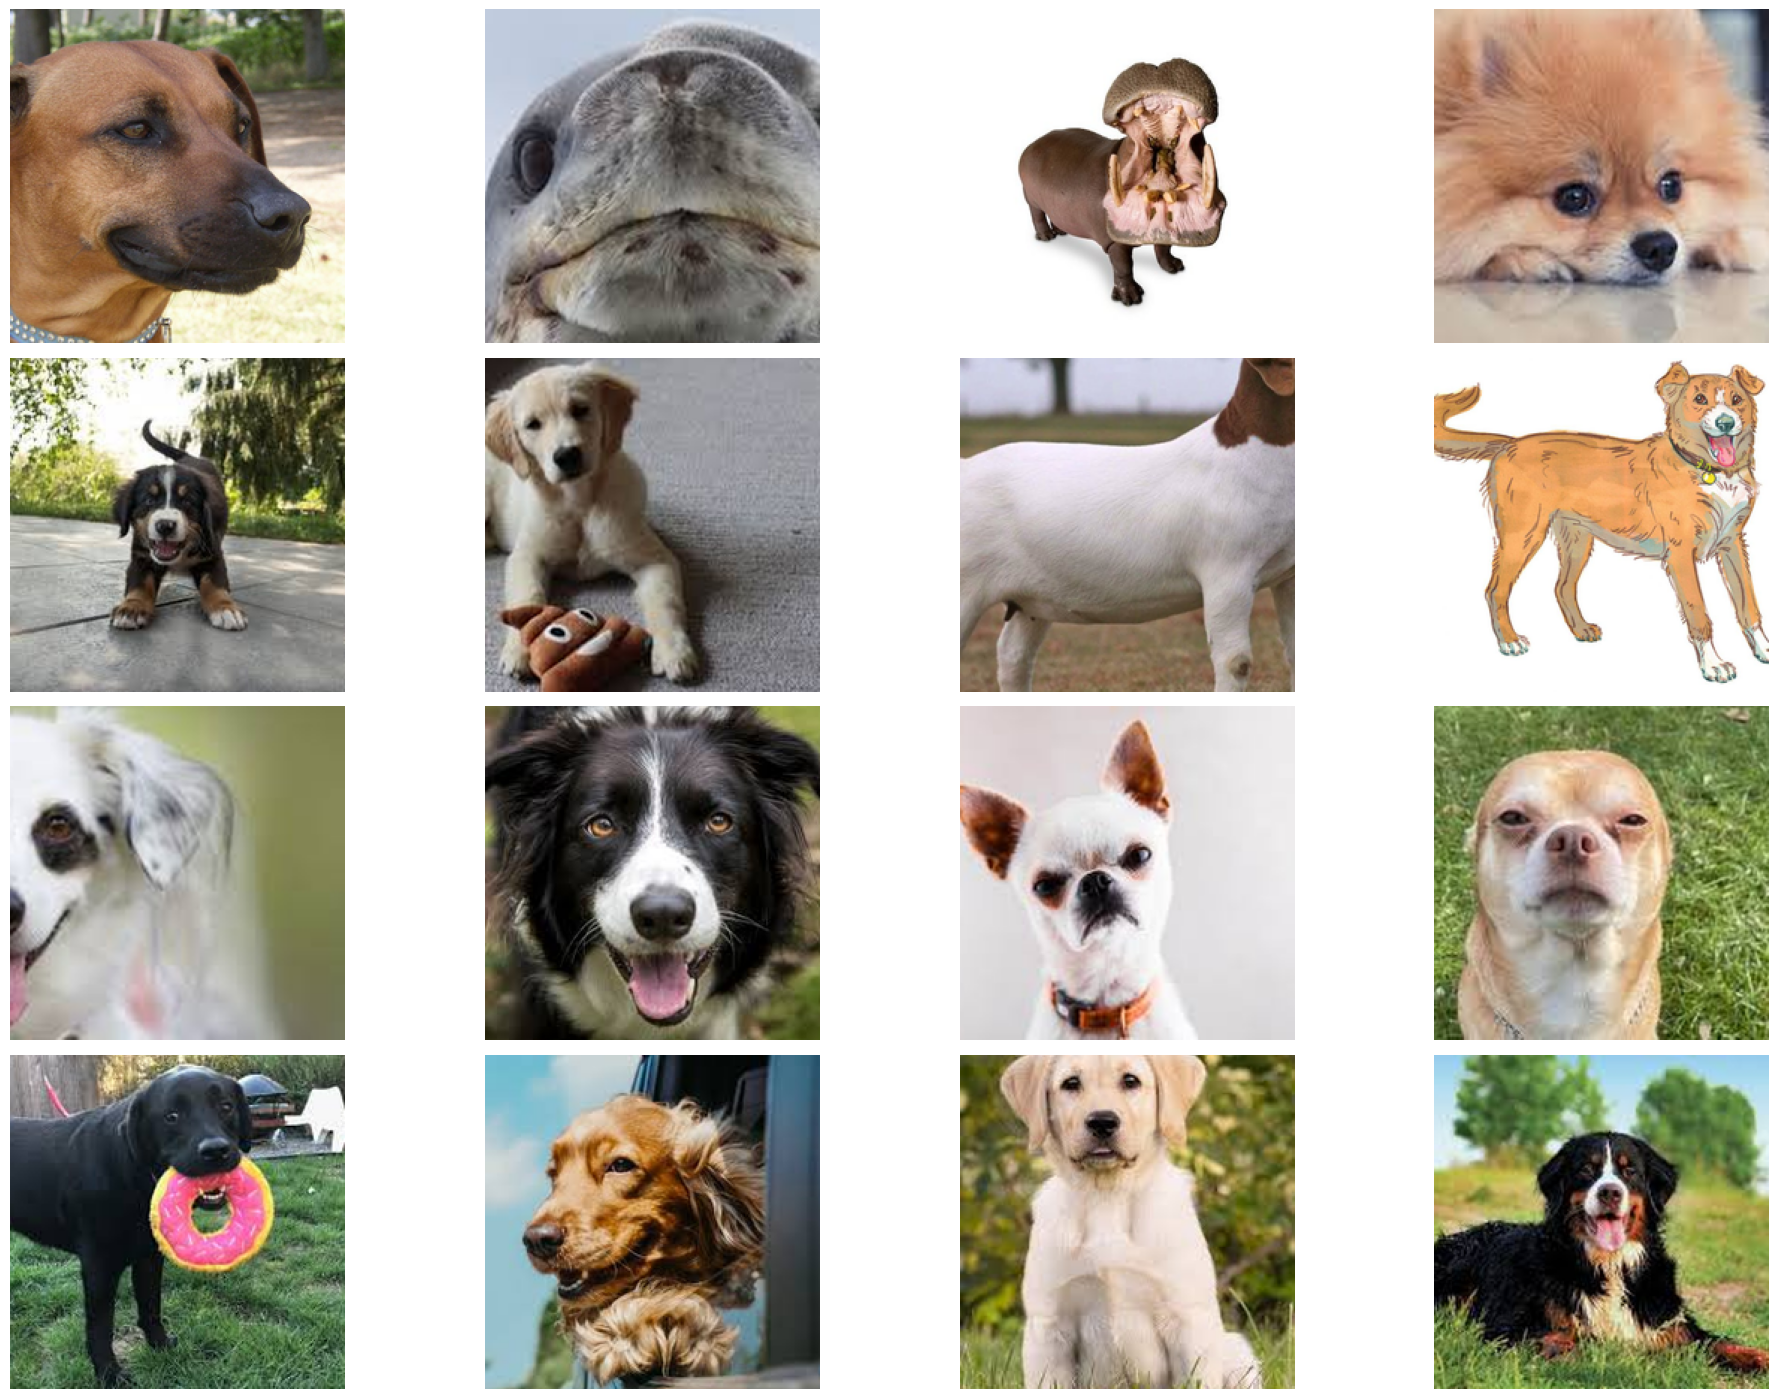

In [10]:
#Plot images on 4x4 grid

grid_size = math.ceil(math.sqrt(number_of_images))
axes = []
fig = plt.figure(figsize=(20, 15))
image_paths = []

for i in range(len(results)):
  axes.append(fig.add_subplot(grid_size, grid_size, i + 1))
  plt.axis('off')
  image_number = results[i][0]
  image_name = image_list[image_number]
  image_paths.append(image_name)
  score = results[i][1]
  img = Image.open(image_name)
  img_resized = ImageOps.fit(img, (224, 224), Image.LANCZOS)
  plt.imshow(img_resized)
#plt.title(f"Image {i}: {score}", fontsize=18)
fig.tight_layout()
fig.subplots_adjust(top=0.93)
plt.show(fig)

In [11]:
# for i in range(len(results)):
#   image_number = results[i][0]
#   image_name = image_list[image_number]
#   score = results[i][1]
#   image = Image.open(image_name)
#   image_resized = ImageOps.fit(image, (224, 224), Image.LANCZOS)
#   plt.figure(figsize=(5, 5))
#   plt.axis('off')
#   plt.title(f"Image {i}: {image_number}: {score}", fontsize=18)
#   plt.imshow(image_resized)
#   plt.show()

In [12]:
!docker run -d -p "6333:6333" -p "6334:6334" --name "reverse_image_search" qdrant/qdrant:v1.3.0

/bin/bash: line 1: docker: command not found


In [13]:
from qdrant_client import QdrantClient
from qdrant_client.http import models as rest

try:
    client = QdrantClient("localhost")
    collections = client.get_collections()
except Exception:
    # Docker is unavailable in Google Colab so we switch to local
    # mode available in Python SDK
    client = QdrantClient(":memory:")
    collections = client.get_collections()

collections

CollectionsResponse(collections=[])

In [14]:
client.recreate_collection(
    collection_name="animals",
    vectors_config=rest.VectorParams(
        size=512,
        distance=rest.Distance.COSINE,
    )
)

True

In [15]:
img_emb_loaded = img_emb_loaded.tolist()
animal_embedding = animal_embedding.tolist()
image_names = range(0,len(image_list))

In [16]:
df = pd.DataFrame(zip(image_names, image_list, img_emb_loaded), columns = ['image_name', 'image_path','embedding'])


In [17]:
# df.to_csv('df_animals.csv', index=False)

In [18]:
# df_loaded.embedding = df_loaded.embedding.apply(lambda x: x.replace('"', ''))

In [19]:
# df_loaded.embedding[0].split()

In [20]:
payloads = df[['image_name', 'image_path']] \
    .fillna("Unknown") \
    .to_dict("records")
payloads[0]

{'image_name': 0, 'image_path': 'animals/animals/porcupine/5e7e817dc9.jpg'}

In [21]:
client.upload_collection(
    collection_name="animals",
    vectors=list(map(list, df["embedding"].tolist())),
    payload=payloads,
    ids=[uuid.uuid4().hex for _ in payloads],
)

In [22]:
# payloads = df_loaded[['image_name', 'image_path']] \
#     .to_dict("records")
# payloads[0]

In [23]:
# import uuid

# client.upload_collection(
#     collection_name="animals",
#     vectors=list(map(list, list(df_loaded["embedding"]).tolist())),
#     payload=payloads,
#     ids=[uuid.uuid4().hex for _ in payloads],
# )


In [24]:
client.count('animals')

CountResult(count=5400)

In [25]:
results = client.search(
        collection_name="animals",
        query_vector=animal_embedding,
        with_payload=True,
        limit=16,
    )

In [26]:
results

[ScoredPoint(id='350e99fd692c4f6ca097cd3f43a27abc', version=0, score=0.2949955840422057, payload={'image_name': 3232, 'image_path': 'animals/animals/dog/17f6784a37.jpg'}, vector=None),
 ScoredPoint(id='9fc84031334a42ebab3c278496181e53', version=0, score=0.28527302755998674, payload={'image_name': 507, 'image_path': 'animals/animals/seal/3a6966dedb.jpg'}, vector=None),
 ScoredPoint(id='b38ad9d0e7ad49b5b73a73a2a2639fe1', version=0, score=0.2831894978225534, payload={'image_name': 5215, 'image_path': 'animals/animals/hippopotamus/2c6bb4dac1.jpg'}, vector=None),
 ScoredPoint(id='e7ac74bd6e884a1bbc1d21ef28c1bcb1', version=0, score=0.2792246943131615, payload={'image_name': 3239, 'image_path': 'animals/animals/dog/8c6a936c9a.jpg'}, vector=None),
 ScoredPoint(id='e4a6d915af7141e19a8db8f60077bc03', version=0, score=0.27747354109257805, payload={'image_name': 3196, 'image_path': 'animals/animals/dog/7a47b70b45.jpg'}, vector=None),
 ScoredPoint(id='b929b8173cb849448080e7421c845bcf', version=0, s

In [27]:
results[0]

ScoredPoint(id='350e99fd692c4f6ca097cd3f43a27abc', version=0, score=0.2949955840422057, payload={'image_name': 3232, 'image_path': 'animals/animals/dog/17f6784a37.jpg'}, vector=None)

In [34]:
# results[0].payload['image_name']

In [35]:
# results[0].payload['image_path']

In [36]:
# results[0].score

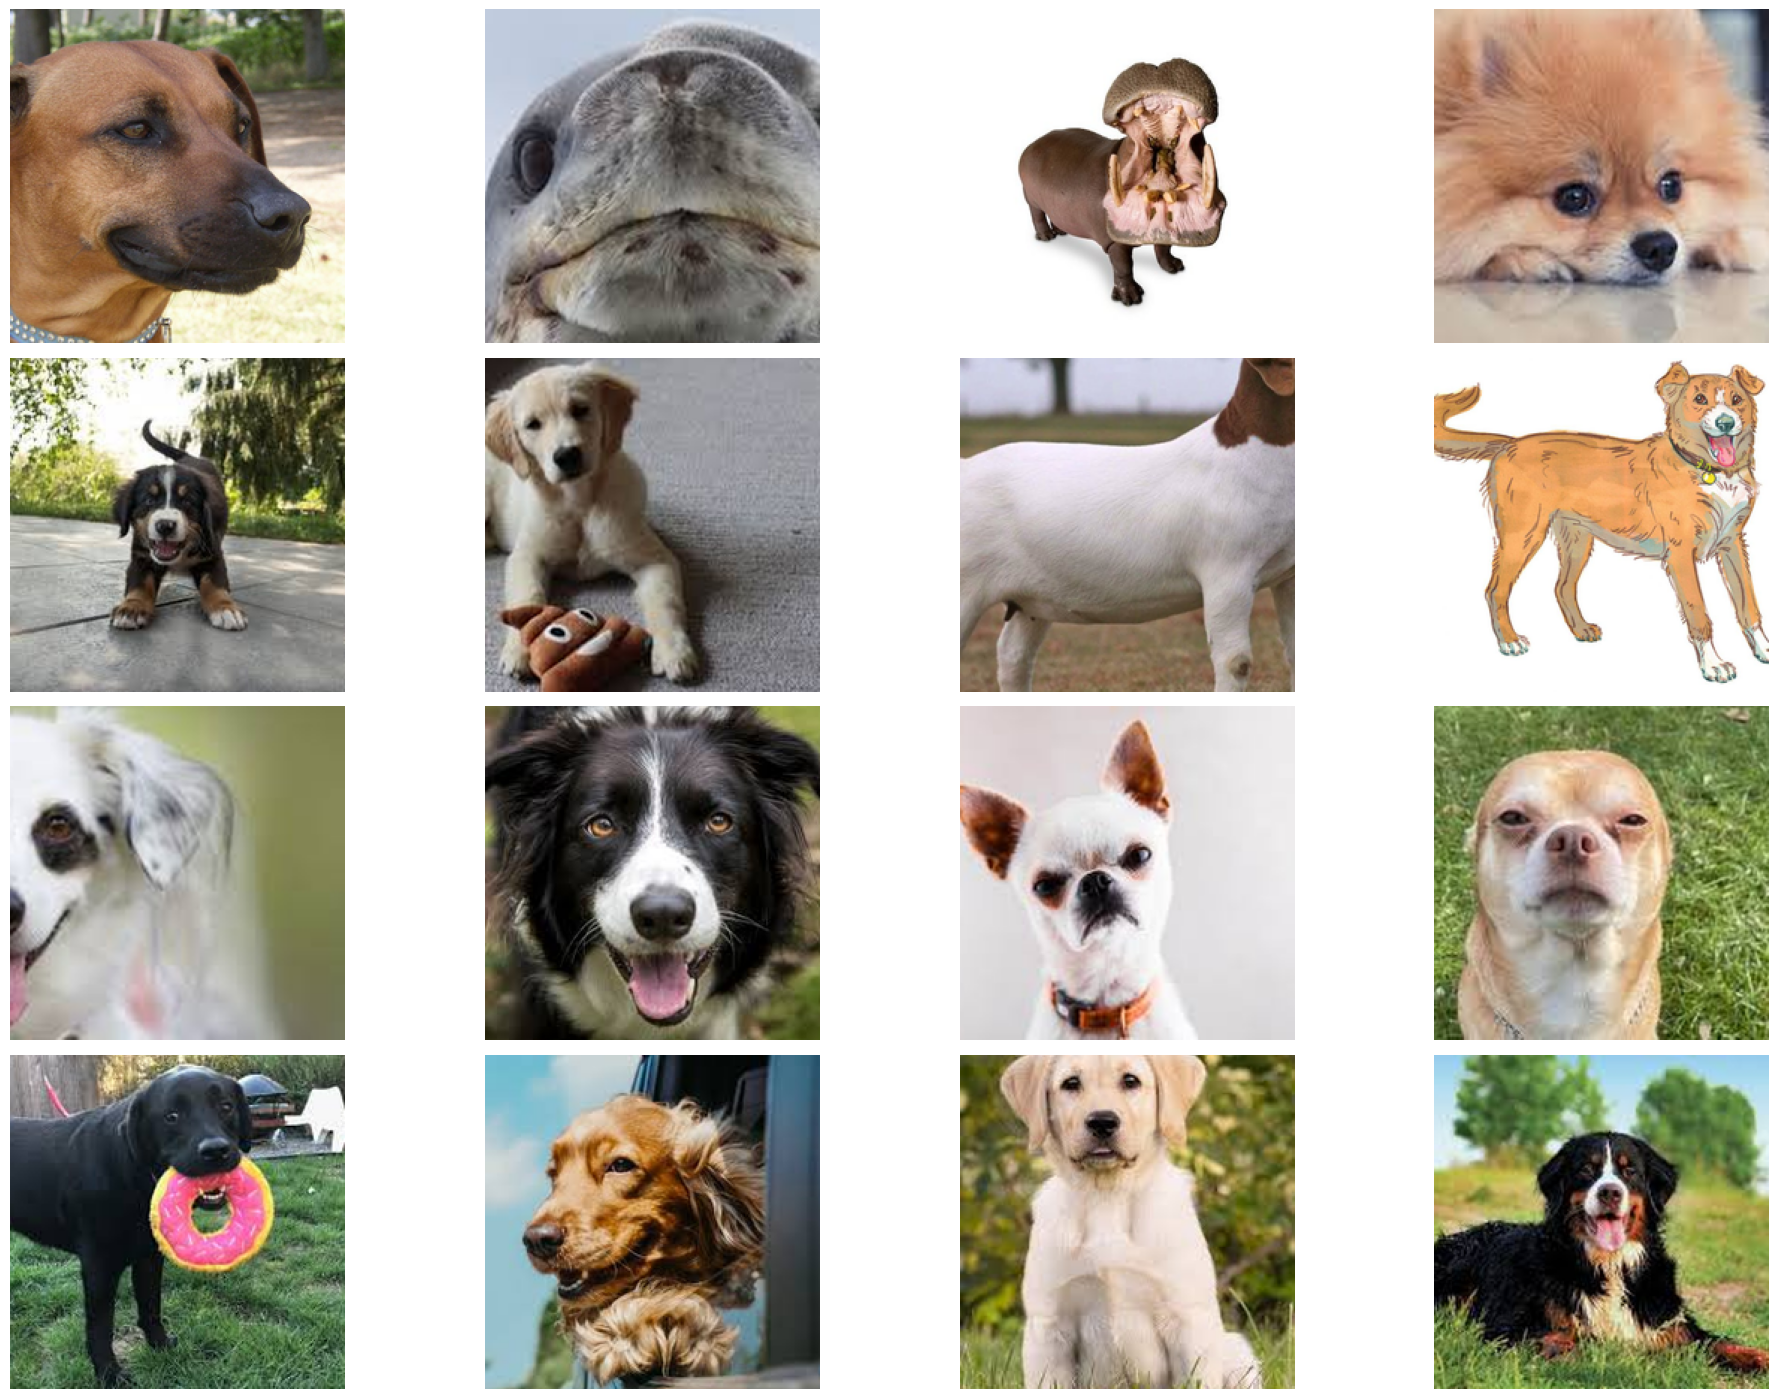

In [31]:
#Plot images on 4x4 grid

grid_size = math.ceil(math.sqrt(number_of_images))
axes = []
fig = plt.figure(figsize=(20, 15))

for i in range(len(results)):
  axes.append(fig.add_subplot(grid_size, grid_size, i + 1))
  plt.axis('off')

  image_name = results[i].payload['image_name']
  image_path = results[i].payload['image_path']
  image_score = results[i].score

  img = Image.open(image_path)
  img_resized = ImageOps.fit(img, (224, 224), Image.LANCZOS)
  plt.imshow(img_resized)
#plt.title(f"Image {i}: {score}", fontsize=18)
fig.tight_layout()
fig.subplots_adjust(top=0.93)
plt.show(fig)

In [32]:
!docker kill reverse_image_search
!docker rm reverse_image_search

/bin/bash: line 1: docker: command not found
/bin/bash: line 1: docker: command not found
